In [1]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [2]:
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"         # make errors point to the right op
#os.environ["TORCH_SHOW_CPP_STACKTRACES"] = "1"   # show C++ stack

In [59]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments


@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'AnyModal/flickr30k'

    coop_prompt_save_path = 's0_coop_flickr30k.pt'

    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 4
    max_epochs: int = 2

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-4
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16
    #fewshot_k: int = 16

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50


cfg = Config()
cfg


Config(image_size=224, batch_size=256, num_workers=4, max_epochs=2, lr_base=1e-05, lr_prompt=0.0001, weight_decay=0.05, unfreeze_layers=(), prompt_len=16, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [5]:
# --- Load model + preprocess ---
clip_model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(clip_model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

In [ ]:
#full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
#full_train_size = len(full_train_ds)
#val_size = int(full_train_size * 0.02)
#
#train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
#overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])
#
#train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
#val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)
#
#overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
#overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)
#
#classnames = full_train_ds.classes
#num_classes = len(classnames)
#
#print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")
#
#def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
#    batch = next(iter(dl))
#    images, labels = batch
#    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
#    for i in range(rows):
#        for j in range(cols):
#            idx = i*cols + j
#            if idx >= len(images):
#                break
#            img = images[idx].permute(1, 2, 0).cpu().numpy()
#            label = classnames[labels[idx]]
#            axs[i, j].imshow(img)
#            axs[i, j].set_title(label)
#            axs[i, j].axis('off')
#    plt.tight_layout()
#    plt.show()
#
#show_batch(val_loader, rows=2, cols=8)

In [8]:
from datasets import DatasetDict

full_ds = datasets.load_dataset(
    cfg.dataset,
    cache_dir="./hf_data",
)

train_ds = full_ds["train"]
val_ds = full_ds["validation"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

train_ds = train_ds.with_transform(transform)
val_ds   = val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    descriptions = [b["alt_text"][0] for b in batch]
    description_ids = tokenizer(descriptions)
    #image_features = clip_model.encode_image(images)
    #image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return {
        "pixel_values": images,
        #"image_features": image_features, # Can be precomputed as the image tower is frozen
        "description": descriptions,
        "description_ids": description_ids,
    }

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

Val dataset:   1014 images with descriptions


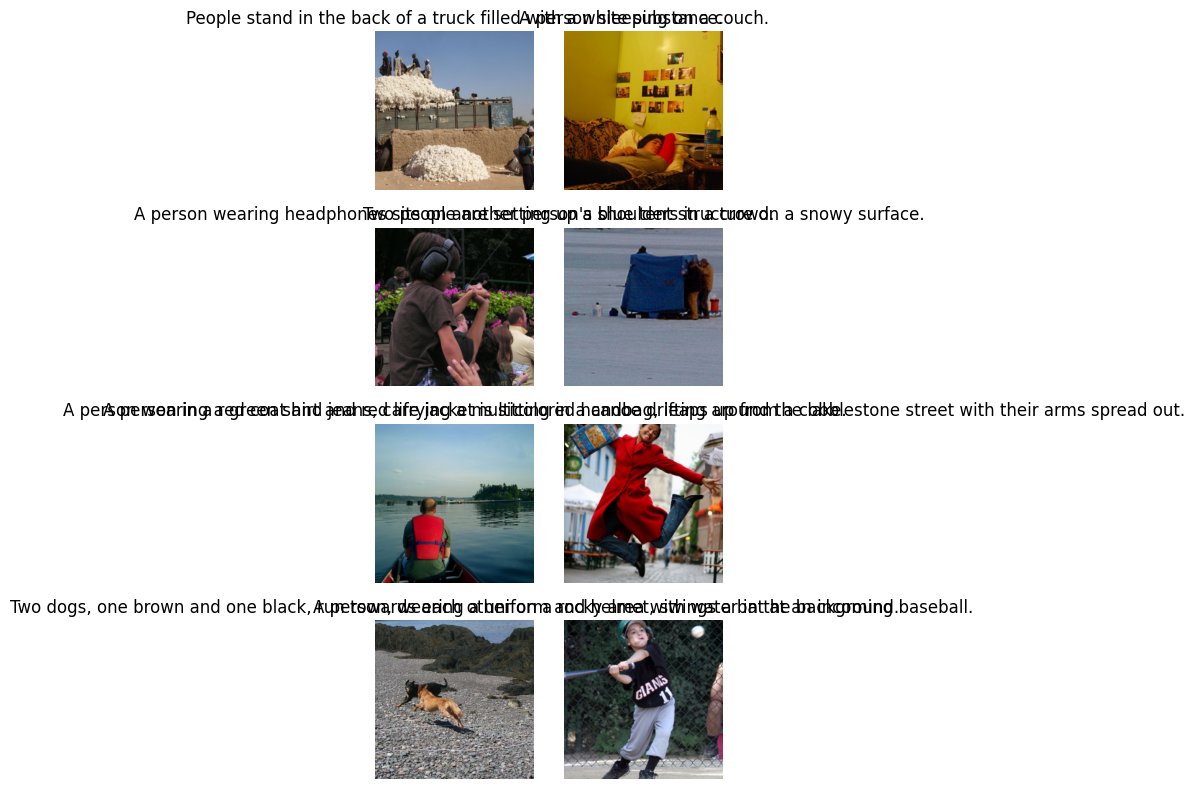

In [9]:
print(f"Val dataset:   {len(val_ds)} images with descriptions")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, descriptions = batch["pixel_values"], batch["description"]
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            desc = descriptions[idx]
            axs[i, j].imshow(img)
            axs[i, j].set_title(desc)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=4, cols=2)

In [ ]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [10]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip, tokenizer, n_ctx=16, init_scale=0.02):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward(self, text_ids):
        #print(text_ids[0])
        eot_indices = text_ids.argmax(dim=-1)
        # text_ids: [B, L]
        B = text_ids.size(0)

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(text_ids)  # [B, L, W]

        sos = tok_emb[:, :1, :]         # [B,1,W]
        description_part = tok_emb[:, 1:, :]  # [B,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(B, -1, -1)  # [B, n_ctx, W]

        # [SOS] + [CTX...CTX] + [description tokens...]
        x = torch.cat([sos, ctx, description_part], dim=1)  # [B, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(B, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot_indices = (eot_indices + self.ctx.size(0)).clamp(max=L-1)
        text_emb = x[torch.arange(B, device=eot_indices.device), eot_indices] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [11]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_prompt):
        super().__init__()
        self.clip = clip
        self.coop_prompt = coop_prompt

        self.clip.requires_grad_(False)
        self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.coop_prompt.train()
        else:
          self.clip.eval()
          self.coop_prompt.eval()

    def forward_text(self, texts):
        return self.coop_prompt(texts)

    def forward_image(self, images):
        image_features = self.clip.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features

    def forward(self, images, texts):
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt(texts)
        logits = 100.0 * image_features @ text_features.T
        return logits

In [12]:
def accuracy(logits): # Accuracy from text to image
    preds = logits.argmax(dim=0)
    labels = torch.arange(0, logits.size(0), device=logits.device)
    correct = (preds == labels).float().mean().item()
    return correct

In [13]:
class SimetricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits):
        bs = logits.size(0)
        labels = torch.arange(bs, device=logits.device)
        loss_1 = self.criterion(logits, labels)
        loss_2 = self.criterion(logits.T, labels)
        return (loss_1 + loss_2) / 2.0

@torch.no_grad()
def evaluate_retrieval(model, test_loader, loss_fn, device, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  all_image_features = []
  all_text_features = []
  for batch in iterator:
    images, description_ids = batch["pixel_values"], batch["description_ids"]
    images = images.to(device, non_blocking=True)
    description_ids = description_ids.to(device, non_blocking=True)

    image_features = model.forward_image(images)
    text_features = model.forward_text(description_ids)

    all_image_features.append(image_features)
    all_text_features.append(text_features)

  # For the true accuracy, it is needed to retrieve the text from all the images
  all_image_features = torch.cat(all_image_features, dim=0)
  all_text_features = torch.cat(all_text_features, dim=0)

  logits = all_image_features @ all_text_features.T

  loss = loss_fn(logits)
  acc = accuracy(logits)
  return loss.item(), acc

def train(
    model, train_loader, val_loader, device="cpu",
    epochs=5, batch_size=256, lr=5e-3, log_train_interval=25, log_val_interval=None
):
    model.to(device)

    print(model.coop_prompt.parameters())
    optimizer = torch.optim.AdamW([model.coop_prompt.ctx], lr=lr)
    loss_fn = SimetricalCrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_time': [], 'val_time': []
    }

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = evaluate_retrieval(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val_time'].append(t)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, batch in enumerate(iterator, start=1):
            images, description_ids = batch["pixel_values"], batch["description_ids"]
            images = images.to(device, non_blocking=True)
            description_ids = description_ids.to(device, non_blocking=True)

            logits = model(images, description_ids)
            loss = loss_fn(logits)
            acc = accuracy(logits)

            history['train_time'].append(t)
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

            if log_val_interval and t % log_val_interval == 0:
                val_loss, val_acc = evaluate_retrieval(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_time'].append(t)
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

        avg_train_loss = np.mean(history['train_loss'][-len(train_loader):])
        avg_train_acc = np.mean(history['train_acc'][-len(train_loader):])
        avg_val_loss = history['val_loss'][-1]
        avg_val_acc = history['val_acc'][-1]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [ ]:
coop_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    n_ctx=cfg.prompt_len,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_prompt,
).to(device)

history = train(
    model=coopclip_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=10,
    log_val_interval=30
)

In [ ]:
loss, acc = evaluate_retrieval(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy after training: {acc}")

In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    # Delete me
    #val_losses = []
    #for val_loss in history['val_loss']:
    #  val_losses.append(val_loss.cpu().item())
    #history['val_loss'] = val_losses
    #del history['val_loss']

    # --- Loss (left) ---
    ax = axes[0]
    ax.plot(history['train_time'], history['train_loss'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_loss' in history and len(history['val_time']) and len(history['val_loss']):
        ax.plot(history['val_time'], history['val_loss'].cpu(), label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    # --- Accuracy (right) ---
    ax = axes[1]
    if 'train_acc' in history and len(history['train_acc']):
        ax.plot(history['train_time'], history['train_acc'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_acc' in history and len(history['val_time']) and len(history['val_acc']):
        ax.plot(history['val_time'], history['val_acc'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    plt.show()

In [ ]:
plot_history(history)

In [ ]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
        }
    }
    torch.save(payload, path)


In [ ]:
save_coop_prompt(coopclip_model.coop_prompt, cfg.coop_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 n_ctx=cfg.prompt_len)

In [15]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  ctx = payload["ctx"]
  n_ctx = payload["meta"]["n_ctx"]
  model_name = payload["meta"]["model_name"]
  if cfg.model_name != model_name:
    raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.modelname: '{cfg.model_name}'")
  coop_prompt = CoOpPrompt(clip, tokenizer, n_ctx)
  with torch.no_grad():
    coop_prompt.ctx.copy_(ctx)

  return coop_prompt

In [16]:
loaded_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_prompt_save_path)

In [20]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=loaded_prompt,
).to(device)

loss, acc = evaluate_retrieval(
    model=loaded_coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for loaded model: {acc}")

Testing CoOpClip on full val:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy for loaded model: 0.7514793276786804


In [21]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 303001 KiB |   4586 MiB | 509625 MiB | 509329 MiB |
|       from large pool | 264832 KiB |   4546 MiB | 509065 MiB | 508807 MiB |
|       from small pool |  38169 KiB |     42 MiB |    559 MiB |    522 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 303001 KiB |   4586 MiB | 509625 MiB | 509329 MiB |
|       from large pool | 264832 KiB |   4546 MiB | 509065 MiB |

In [56]:
from PIL import Image

@torch.no_grad()
def precompute_image_features(model, loader):
  loaded_coopclip_model.eval()
  image_features = []
  for batch in loader:
    images = batch["pixel_values"]
    images = images.to(device, non_blocking=True)
    image_features.append(loaded_coopclip_model.forward_image(images).detach().cpu())
  image_features = torch.cat(image_features, dim=0)
  return image_features

val_image_features = precompute_image_features(loaded_coopclip_model, val_loader)
#plt.imshow(best_image[0].permute(1, 2, 0))

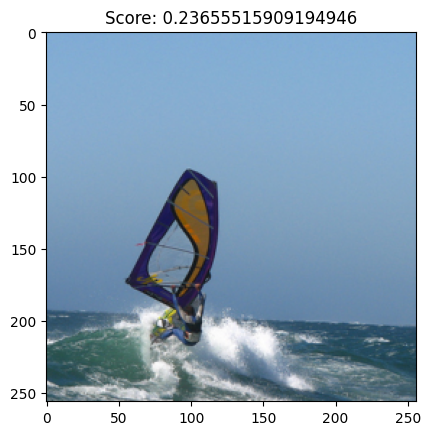

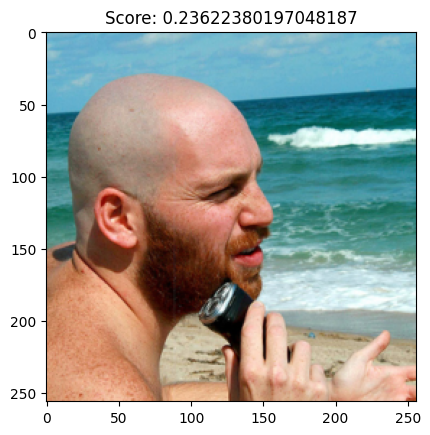

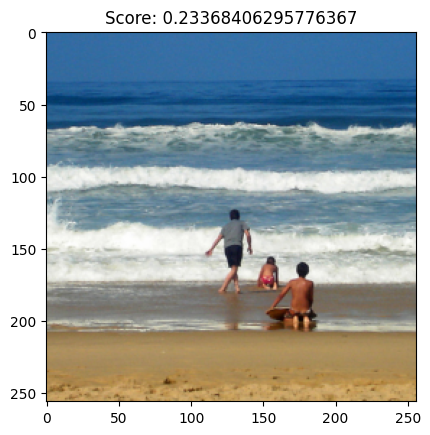

In [96]:
@torch.no_grad()
def retrieve(model, text, image_features, top_k=1):
    image_features = image_features.to(device)
    model.to(device)
    model.eval()

    text_features = model.forward_text(tokenizer(text).to(device))

    logits = image_features @ text_features.T
    logits = logits.squeeze(1)
    preds = (-logits).argsort(dim=0)[:top_k].detach().cpu()
    scores = logits[preds].detach().cpu()

    return preds, scores

top_k = 3

preds, scores = retrieve(loaded_coopclip_model, "Ocean", val_image_features, top_k=top_k)

for i in range(top_k):
    image = torch.as_tensor(val_loader.dataset[preds[i].item()]['pixel_values'])
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Score: {scores[i]}")
    plt.show()

In [52]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 332791 KiB |  14782 MiB |   2408 GiB |   2407 GiB |
|       from large pool | 264832 KiB |  14715 MiB |   2406 GiB |   2406 GiB |
|       from small pool |  67959 KiB |     96 MiB |      1 GiB |      1 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 332791 KiB |  14782 MiB |   2408 GiB |   2407 GiB |
|       from large pool | 264832 KiB |  14715 MiB |   2406 GiB |

In [51]:
import torch, math

def list_cuda_tensors(namespace=None):
    if namespace is None:
        namespace = globals()
    rows = []
    for name, obj in list(namespace.items()):
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            mb = obj.numel() * obj.element_size() / (1024**2)
            rows.append((name, tuple(obj.shape), str(obj.dtype), str(obj.device), f"{mb:.1f} MB"))
    rows.sort(key=lambda r: float(r[-1].split()[0]), reverse=True)
    for r in rows:
        print(r)
list_cuda_tensors()

('text_features', (1, 512), 'torch.float32', 'cuda:0', '0.0 MB')


In [50]:
import gc, torch
# drop any live refs
images = image_features = logits = pred = None
gc.collect()
torch.cuda.empty_cache()


In [ ]:
#coop, history = train_coop(
#    model=model,
#    tokenizer=tokenizer,
#    classnames=classnames,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    n_ctx=cfg.prompt_len,
#    epochs=cfg.max_epochs,
#    batch_size=cfg.batch_size,
#    lr=cfg.lr_prompt,
#    num_workers=cfg.num_workers,
#)

In [ ]:
# 10) Extra analysis: (optional) confusion matrix if sklearn is available
try:
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False, desc='cm'):
            p = coopclip_model(x.to(device)).argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Install scikit-learn to see confusion matrix. Skipping. Error:', e)